# Virality Predictor

In this project, we use supervised learning models to identify customers who are likely to stop using service in the future.


## Contents

1. Import Data and Packages
2. Feature Preprocessing
3. Model Training and Result Evaluation
4. Summary

## 1. Import Data and Packages

In [239]:
#import useful packages
import numpy as np
import pandas as pd
import io
from pandas_profiling import ProfileReport
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import warnings

In [211]:
#read shared articles csv
df_shared = pd.read_csv('shared_articles.csv')
df_shared

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,1487946604,CONTENT SHARED,9213260650272029784,3609194402293569455,7144190892417579456,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt
3118,1487947067,CONTENT SHARED,-3295913657316686039,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en
3119,1488223224,CONTENT SHARED,3618271604906293310,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en
3120,1488300719,CONTENT SHARED,6607431762270322325,-1393866732742189886,2367029511384577082,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en


In [212]:
#dropping CONTENT REMOVED in eventType column
df_shared = df_shared[df_shared['eventType'] != 'CONTENT REMOVED']
df_shared

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,1487946604,CONTENT SHARED,9213260650272029784,3609194402293569455,7144190892417579456,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt
3118,1487947067,CONTENT SHARED,-3295913657316686039,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en
3119,1488223224,CONTENT SHARED,3618271604906293310,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en
3120,1488300719,CONTENT SHARED,6607431762270322325,-1393866732742189886,2367029511384577082,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en


In [213]:
#Read users interactions csv
df_users = pd.read_csv('users_interactions.csv')
df_users

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
72307,1485190425,LIKE,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
72308,1485190425,VIEW,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
72309,1485190072,VIEW,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR
72310,1485190434,VIEW,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR


## 2. Feature Preprocessing
### 2.1 Compute VIRALITY

In [214]:
#join two dataframes
df_users = df_users.drop('timestamp', axis = 1)
df_all = pd.merge(df_shared, df_users, how='right', on=['contentId', 'contentId'])
df_all

,timestamp,eventType_x,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,eventType_y,personId,sessionId,userAgent,userRegion,userCountry
0,1.459194e+09,CONTENT SHARED,-4110354420726924665,4.340307e+18,8.940341e+18,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,VIEW,2873028073541627603,-3228450896145227905,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR
1,1.459194e+09,CONTENT SHARED,-7292285110016212249,4.340307e+18,8.940341e+18,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,VIEW,8414731042150985013,4543899740167763020,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
2,1.459194e+09,CONTENT SHARED,-6151852268067518688,3.891638e+18,-1.457533e+18,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,VIEW,-7267769888748948232,-1350132153769633851,Android - Native Mobile App,MG,BR
3,1.459194e+09,CONTENT SHARED,-6151852268067518688,3.891638e+18,-1.457533e+18,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,VIEW,-7267769888748948232,-1350132153769633851,Android - Native Mobile App,MG,BR
4,1.459194e+09,CONTENT SHARED,-6151852268067518688,3.891638e+18,-1.457533e+18,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,LIKE,-7267769888748948232,-1350132153769633851,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72307,NaN,NaN,1556878199027930272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,-3596626804281480007,-1265674411417879659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR
72308,NaN,NaN,1556878199027930272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,-2772844562500836582,5598025444314523127,Android - Native Mobile App,SP,BR
72309,NaN,NaN,1556878199027930272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,6648370769037295216,7380699131641248656,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR
72310,NaN,NaN,1556878199027930272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,-5230721907253934520,-325266336179767956,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,SP,BR


In [215]:
#Here we group by rows by eventType_y and count each kind of event
df_all['COUNTER'] = 1 
group_data = df_all.groupby(['contentId','eventType_y'])['COUNTER'].sum().reset_index() 
df_all = df_all.drop('COUNTER',axis = 1)
group_data

,contentId,eventType_y,COUNTER
0,-9222795471790223670,BOOKMARK,1
1,-9222795471790223670,COMMENT CREATED,2
2,-9222795471790223670,FOLLOW,3
3,-9222795471790223670,LIKE,4
4,-9222795471790223670,VIEW,16
...,...,...,...
7335,9217155070834564627,COMMENT CREATED,2
7336,9217155070834564627,VIEW,14
7337,9220445660318725468,LIKE,2
7338,9220445660318725468,VIEW,50


In [216]:
# we create a pivot table to get event counts for each contentId
df_event = group_data.pivot_table('COUNTER', ['contentId'], 'eventType_y')
df_event = df_event.fillna(0)
df_event

eventType_y,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW
contentId,,,,,
-9222795471790223670,1.0,2.0,3.0,4.0,16.0
-9216926795620865886,1.0,1.0,1.0,3.0,15.0
-9194572880052200111,2.0,1.0,1.0,4.0,21.0
-9192549002213406534,0.0,1.0,0.0,5.0,50.0
-9190737901804729417,0.0,0.0,0.0,1.0,8.0
...,...,...,...,...,...
9213260650272029784,0.0,0.0,0.0,0.0,11.0
9215261273565326920,3.0,0.0,0.0,3.0,24.0
9217155070834564627,0.0,2.0,0.0,0.0,14.0


In [217]:
#calculate VIRALITY
df_event['VIRALITY'] = df_event.apply(lambda x: (1* x['VIEW']) + (4*x['LIKE']) + (10*x['COMMENT CREATED']) +(25*x['FOLLOW'] )+ (100*x['BOOKMARK']), axis=1)
df_event = df_event.reset_index()
df_event

eventType_y,contentId,BOOKMARK,COMMENT CREATED,FOLLOW,LIKE,VIEW,VIRALITY
0,-9222795471790223670,1.0,2.0,3.0,4.0,16.0,227.0
1,-9216926795620865886,1.0,1.0,1.0,3.0,15.0,162.0
2,-9194572880052200111,2.0,1.0,1.0,4.0,21.0,272.0
3,-9192549002213406534,0.0,1.0,0.0,5.0,50.0,80.0
4,-9190737901804729417,0.0,0.0,0.0,1.0,8.0,12.0
...,...,...,...,...,...,...,...
2982,9213260650272029784,0.0,0.0,0.0,0.0,11.0,11.0
2983,9215261273565326920,3.0,0.0,0.0,3.0,24.0,336.0
2984,9217155070834564627,0.0,2.0,0.0,0.0,14.0,34.0
2985,9220445660318725468,0.0,0.0,0.0,2.0,50.0,58.0


In [218]:
# columns used to calculate VIRALITY are dropped
df_event = df_event.drop(['BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW'], axis = 1)
df_new = pd.merge(df_shared, df_event, how='inner', on=['contentId', 'contentId'])
# columns representing ids and used to calculating VIRALITY are alsodropped
df_new = df_new.drop(['contentId', 'authorPersonId', 'authorSessionId'], axis = 1)
df_new

,timestamp,eventType,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,VIRALITY
0,1459193988,CONTENT SHARED,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1.0
1,1459194146,CONTENT SHARED,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,1.0
2,1459194474,CONTENT SHARED,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,22.0
3,1459194522,CONTENT SHARED,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,2.0
4,1459194599,CONTENT SHARED,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/blockchai...,Blockchain Technology Could Put Bank Auditors ...,When most people think about computers and rob...,en,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2974,1487946604,CONTENT SHARED,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt,11.0
2975,1487947067,CONTENT SHARED,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,3.0
2976,1488223224,CONTENT SHARED,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,1.0
2977,1488300719,CONTENT SHARED,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,1.0


###  2.2 Exploratory Data Analysis

In [219]:
# executed EDA by using pandas profiling package
profile = ProfileReport(df_new)
profile

### 2.3 Feature Engineering

In [220]:
# From the EDA report we can see that the dataset, 
# especially author-related columns, contain too many missing values,
# so we can drop those missing values to simplify analysis process
# Assume that the auther-related columns and url column are irrelavent to VIRALITY, those features are set to be dropped
# Only 7 articles unsung language other than English or Portuguese, so we're also dropping them to simplify the labeling process
df_new = df_new.drop(['authorUserAgent','authorRegion','authorCountry','eventType', 'url'], axis = 1)
df_new = df_new.dropna()
df_new.drop(df_new[df_new['lang'] == 'la'].index, inplace = True) 
df_new.drop(df_new[df_new['lang'] == 'ja'].index, inplace = True) 
df_new.drop(df_new[df_new['lang'] == 'es'].index, inplace = True) 
df_new

,timestamp,contentType,title,text,lang,VIRALITY
0,1459193988,HTML,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1.0
1,1459194146,HTML,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,1.0
2,1459194474,HTML,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,22.0
3,1459194522,HTML,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,2.0
4,1459194599,HTML,Blockchain Technology Could Put Bank Auditors ...,When most people think about computers and rob...,en,1.0
...,...,...,...,...,...,...
2974,1487946604,HTML,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt,11.0
2975,1487947067,HTML,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,3.0
2976,1488223224,HTML,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,1.0
2977,1488300719,HTML,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,1.0


In [221]:
# here we use nltk module to analyze how many words/tokens in text and titles, and generate new features

nltk.download('punkt')
nltk.download('stopwords')
stopwordsEn = nltk.corpus.stopwords.words('english')
stopwordsPt = nltk.corpus.stopwords.words('portuguese')
def tokenization(text, lang):
    if lang == "en":
        stopwords = stopwordsEn
    else: 
        stopwords = stopwordsPt
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    num_of_tokens = 0
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            num_of_tokens += 1
    return num_of_tokens

[nltk_data] Downloading package punkt to /Users/yunruixie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunruixie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
df_new['numOfTokens'] = df_new.apply(lambda x: tokenization(x['text'], x['lang']), axis = 1)
df_new['numOfTokensTitle'] = df_new.apply(lambda x: tokenization(x['title'], x['lang']), axis = 1)
df_new['numOfWords'] = df_new.text.apply(lambda x: len(x.split()))
df_new

,timestamp,contentType,title,text,lang,VIRALITY,numOfTokens,numOfTokensTitle,numOfWords
0,1459193988,HTML,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1.0,626,9,1072
1,1459194146,HTML,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,1.0,219,9,311
2,1459194474,HTML,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,22.0,160,4,272
3,1459194522,HTML,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,2.0,168,7,276
4,1459194599,HTML,Blockchain Technology Could Put Bank Auditors ...,When most people think about computers and rob...,en,1.0,462,8,727
...,...,...,...,...,...,...,...,...,...
2974,1487946604,HTML,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt,11.0,281,12,453
2975,1487947067,HTML,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,3.0,189,8,297
2976,1488223224,HTML,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,1.0,1698,3,2662
2977,1488300719,HTML,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,1.0,673,8,1029


In [223]:
# here we use sentiment analyzer to get a compound sentiment score as our new feature
def sentiment_scores(sentence): 
    analyzer = SentimentIntensityAnalyzer() 
    sentiment_dict = analyzer.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [224]:
df_new['sentimentScore'] = df_new.text.apply(lambda x: sentiment_scores(x))
df_new

,timestamp,contentType,title,text,lang,VIRALITY,numOfTokens,numOfTokensTitle,numOfWords,sentimentScore
0,1459193988,HTML,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1.0,626,9,1072,0.9993
1,1459194146,HTML,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,1.0,219,9,311,0.9611
2,1459194474,HTML,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,22.0,160,4,272,0.9919
3,1459194522,HTML,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,2.0,168,7,276,0.8119
4,1459194599,HTML,Blockchain Technology Could Put Bank Auditors ...,When most people think about computers and rob...,en,1.0,462,8,727,0.9985
...,...,...,...,...,...,...,...,...,...,...
2974,1487946604,HTML,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt,11.0,281,12,453,-0.7783
2975,1487947067,HTML,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,3.0,189,8,297,0.9682
2976,1488223224,HTML,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,1.0,1698,3,2662,0.9999
2977,1488300719,HTML,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,1.0,673,8,1029,0.9943


In [225]:
#we use one-hot encoding on lang and contentType column, and drop title and text columns
df_new['lang'] = df_new.lang.apply(lambda x: 1 if x == "en" else 0)
df_dummies = pd.get_dummies(df_new.contentType, prefix='contentType')
df_new = pd.concat([df_new, df_dummies], axis=1)
df_new = df_new.drop(['contentType', 'title', 'text'], axis = 1)
df_new

,timestamp,lang,VIRALITY,numOfTokens,numOfTokensTitle,numOfWords,sentimentScore,contentType_HTML,contentType_RICH,contentType_VIDEO
0,1459193988,1,1.0,626,9,1072,0.9993,1,0,0
1,1459194146,1,1.0,219,9,311,0.9611,1,0,0
2,1459194474,1,22.0,160,4,272,0.9919,1,0,0
3,1459194522,1,2.0,168,7,276,0.8119,1,0,0
4,1459194599,1,1.0,462,8,727,0.9985,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2974,1487946604,0,11.0,281,12,453,-0.7783,1,0,0
2975,1487947067,1,3.0,189,8,297,0.9682,1,0,0
2976,1488223224,1,1.0,1698,3,2662,0.9999,1,0,0
2977,1488300719,1,1.0,673,8,1029,0.9943,1,0,0


In [226]:

df_new['timestamp'] = df_new['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_new['dayOfWeek'] = df_new['timestamp'].apply(lambda x: x.day_name())
df_dummies = pd.get_dummies(df_new.dayOfWeek, prefix='dayOfWeek')
df_new = pd.concat([df_new, df_dummies], axis=1)
df_new['isWeekend'] = df_new.dayOfWeek.apply(lambda x: 1 if x == 'Saturday' or x == 'Sunday' else 0)
df_new = df_new.drop(['timestamp', 'dayOfWeek'], axis = 1)
df_new

,lang,VIRALITY,numOfTokens,numOfTokensTitle,numOfWords,sentimentScore,contentType_HTML,contentType_RICH,contentType_VIDEO,dayOfWeek_Friday,dayOfWeek_Monday,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday,isWeekend
0,1,1.0,626,9,1072,0.9993,1,0,0,0,1,0,0,0,0,0,0
1,1,1.0,219,9,311,0.9611,1,0,0,0,1,0,0,0,0,0,0
2,1,22.0,160,4,272,0.9919,1,0,0,0,1,0,0,0,0,0,0
3,1,2.0,168,7,276,0.8119,1,0,0,0,1,0,0,0,0,0,0
4,1,1.0,462,8,727,0.9985,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,0,11.0,281,12,453,-0.7783,1,0,0,1,0,0,0,0,0,0,0
2975,1,3.0,189,8,297,0.9682,1,0,0,1,0,0,0,0,0,0,0
2976,1,1.0,1698,3,2662,0.9999,1,0,0,0,1,0,0,0,0,0,0
2977,1,1.0,673,8,1029,0.9943,1,0,0,0,0,0,0,0,1,0,0


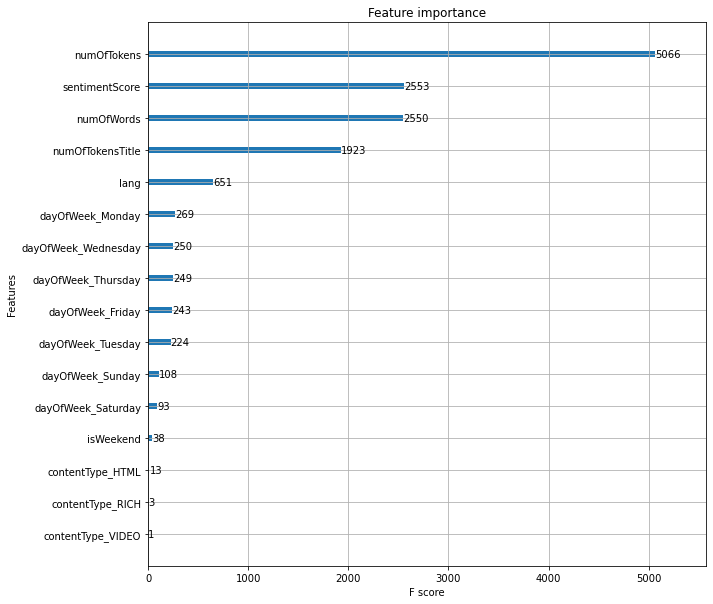

In [227]:
# using xgboost to get feature importance and visualization
xgb = XGBRegressor(max_depth = 10,random_state = 42)
xgb.fit(X, y)
fig, ax = plt.subplots(1,1,figsize=(10,10))
impplot = plot_importance(xgb,ax = ax)
plt.show()

## 3. Model Training and Result Evaluation


In [228]:
# train-test split and standardization
X =  df_new.drop(["VIRALITY"],axis = 1)
y = df_new["VIRALITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print('Training data has %d observation with %d features'% X_train.shape)
print('Test data has %d observation with %d features'% X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training data has 2229 observation with 16 features
Test data has 743 observation with 16 features


### 3.1 Linear Regression with Ridge regularization

In [248]:
model = Ridge(alpha = 1.0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print('Model RMSE of Ridge Regression is: %.3f'%(cv_score.mean()))

Model RMSE of Ridge Regression is: -202.623


###  3.2 XGBoost

In [246]:
xgb2 = XGBRegressor(random_state = 42,verbosity=0)
boost = ['gbtree','gblinear']
warnings.filterwarnings("ignore")
xgb2.max_depth = 10
for b in boost:
    xgb2.booster = b
    xgb2.fit(X_train,y_train)
    y_pred = xgb2.predict(X_test)
    cv_score = cross_val_score(xgb2, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print('Model RMSE of XGBoost %s is: %.3f'%(b, cv_score.mean()))

Model RMSE of XGBoost gbtree is: -228.719
Model RMSE of XGBoost gblinear is: -202.272


### 3.3 Support Vector Regressor

In [244]:
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print('Model RMSE of SVR is: %.3f'%(cv_score.mean()))

Model RMSE of SVR is: -219.857


### 3.4 Conclusion
From the evaluation results, we can choose XGBoost with gblinear as booster where results with lowest RMSE

## 4. Summary
#### What features did you consider?
- Number of tokens(unique non-stop words)in text/title
- Number of words in text
- Day of week that the article was shared(0/1 for each day of week)
- Was the article shared on weekend(0/1 for weekday/weekend)
- Language of the article(0/1 for pt/en)
- Content type of the article(HTML/Rich/Video)
- Sentimental score(The compound score from -1 to 1 represent sentiment from most negative to most positive)

#### What model did you use and why?
Since it is a regression problem, I applied Linear Regression, XGBoost and SVR models because:

XGBoost is an ensemble learning method, which can reduce overfitting, can capture non-linear relationship, has a high explainability, and will keep robust with outliers

Linear regression can capture linear replationship between independent variables and dependent variables. It also has a high explainability and is easy to implement. Here I applied ridge regression to prevent overfitting and reduce multicolinearity.

SVR can capture non-linear relationship between independent variables and dependent varialbes. It is easily adaptable and not biased by outliers.

#### What was your evaluation metric for this? 
My evaluation metric used for this project is RMSE because it's the best metric when comparing accuracy between models.

#### What features would you like to add to the model in the future if you had more time?
If there's more time, I'd like to:
- not dropping CONTENT REMOVED rows in contentId column, but labeling those articles got removed later with dummy variables
- not dropping url column, but to strip website source data to get a new feature
- combine time zone and user interactions to check if readers' behaviors have certain patterns(e.g.: they are more likely to engage at night instead of during the day)
- include author-related features into models

#### What other things would you want to try before deploying this model in production.

Use grid search tuning hyperparameters for each model to improve efficiency.
Looking for more data to train to avoid high variance.
Testing on more models to compare the results.